# Lab 3: Foundations of Deep Learning

Welcome to Lab 3! In this notebook, we will move beyond simple linear models and build the intuition behind **Deep Learning** from the ground up. We will explore why we need multi-layer networks, how they work mathematically, and how they learn.

### **Learning Objectives:**
By the end of this lab, you will understand:
1. **The XOR Problem**: The fundamental limitation of linear models that necessitates "Deep" Learning.
2. **Activation Functions**: The crucial component that introduces non-linearity, allowing networks to learn complex patterns.
3. **Forward Propagation**: The step-by-step mechanism of how data flows through a neural network to produce a prediction.
4. **Gradient Descent**: The optimization algorithm that powers the learning process by minimizing error.
5. **Shallow Networks**: Constructing and training a 2-layer Neural Network to solve the XOR problem.
6. **Universal Approximation Theorem**: The theoretical guarantee that neural networks can approximate any continuous function.

In [13]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Setting random seed for reproducibility ensures that our random weights are the same every time we run this.
torch.manual_seed(42)
np.random.seed(42)

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

## 1. The XOR Problem (Motivation)

To understand why Neural Networks are necessary, we first need to understand the limitations of simpler models. 

The **Exclusive OR (XOR)** function is a classic problem in the history of AI. It is a binary classification problem where we have two binary inputs ($x_1, x_2$). The output is `1` if the inputs are *different*, and `0` if they are the *same*.

### True Table:
| Input 1 ($x_1$) | Input 2 ($x_2$) | Output ($y$) |
| :---: | :---: | :---: |
| 0 | 0 | 0 |
| 0 | 1 | 1 |
| 1 | 0 | 1 |
| 1 | 1 | 0 |

Let's visualize this dataset on a 2D plane.

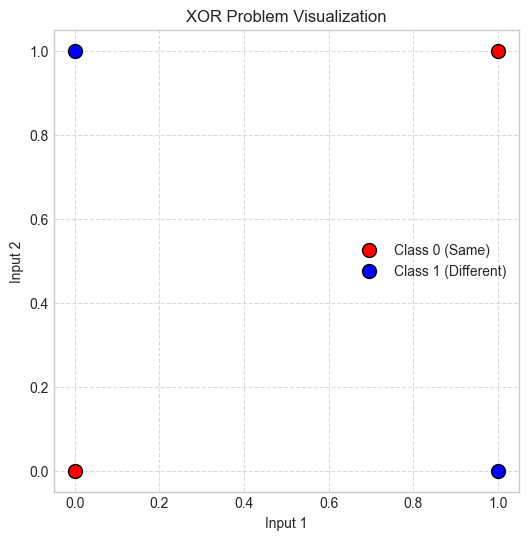

In [14]:
X = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
y = torch.tensor([0, 1, 1, 0], dtype=torch.float32)

def plot_xor(model=None):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[y==0, 0], X[y==0, 1], c='red', label='Class 0 (Same)', s=100, edgecolors='k')
    plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', label='Class 1 (Different)', s=100, edgecolors='k')
    
    if model:
        # Create a meshgrid to visualize the decision boundary drawn by the model
        x_min, x_max = -0.5, 1.5
        y_min, y_max = -0.5, 1.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
        grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
        
        with torch.no_grad():
            out = model(grid).reshape(xx.shape)
            
        plt.contourf(xx, yy, out, alpha=0.3, cmap='coolwarm')
        
    plt.legend(loc='center right')
    plt.title("XOR Problem Visualization")
    plt.xlabel("Input 1")
    plt.ylabel("Input 2")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

plot_xor()

### Why is this hard?
Look at the plot above. Try to draw a **single straight line** that completely separates the red dots from the blue dots. 

You will find that it is **impossible**. No matter how you draw a straight line, you will always misclassify at least one point. 

**This is the definition of Linear Inseparability.**

- **Linear Models** (like Logistic Regression or a single Perceptron) are restricted to drawing linear decision boundaries (straight lines in 2D, planes in 3D).
- Because the XOR problem is not linearly separable, a single neuron is mathematically incapable of solving it. 

To solve this, we need a model that can draw *curved* or *complex* boundaries. We need a Neural Network.

## 2. Activation Functions (The "Why" and "How")

How do we get curved boundaries from linear operations? 

A standard neuron performs a linear operation: $z = w \cdot x + b$. If we stack many of these layers together without doing anything else, the result is still just one big linear operation (because a linear combination of linear functions is still a linear function).

To introduce complexity, we apply a non-linear **Activation Function** ($\sigma$) after each linear step: $a = \sigma(z)$. This "bends" the space, allowing the network to learn non-linear patterns.

Let's visualize the most common activation functions used in Deep Learning:

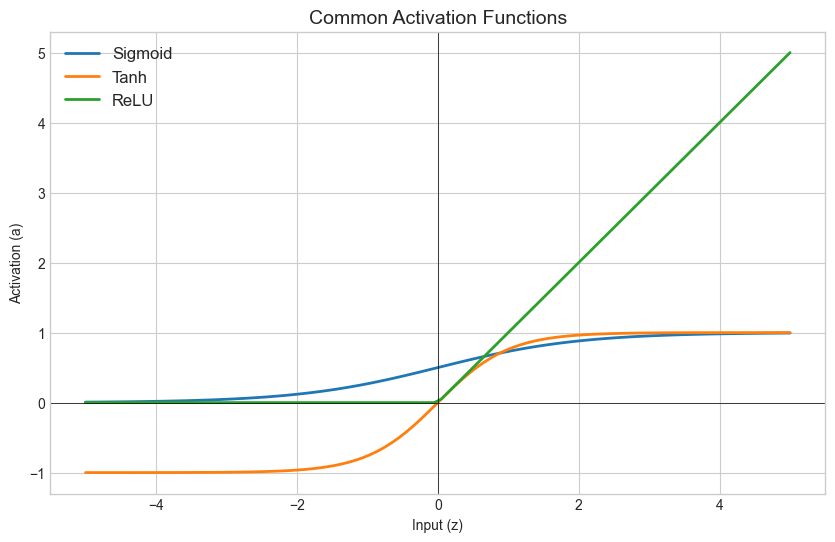

In [15]:
x_vals = torch.linspace(-5, 5, 100)

def plot_activation(name, func):
    y_vals = func(x_vals)
    plt.plot(x_vals.numpy(), y_vals.numpy(), label=name, linewidth=2)

plt.figure(figsize=(10, 6))
plot_activation("Sigmoid", torch.sigmoid)
plot_activation("Tanh", torch.tanh)
plot_activation("ReLU", torch.relu)

plt.legend(fontsize=12)
plt.title("Common Activation Functions", fontsize=14)
plt.xlabel("Input (z)")
plt.ylabel("Activation (a)")
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True)
plt.show()

### Comparison of Functions:

1. **Sigmoid** ($\sigma(x) = \frac{1}{1+e^{-x}}$):
   - **Shape**: S-curve. Squashes values between 0 and 1.
   - **Use**: Historically very popular. Now mostly used in the **output layer** for binary classification (probability).
   - **Cons**: Suffers from the "Vanishing Gradient" problem (gradients become tiny at the tails), making deep networks hard to train.

2. **Tanh** (Hyperbolic Tangent):
   - **Shape**: S-curve. Squashes values between -1 and 1.
   - **Use**: Often preferred over Sigmoid for hidden layers because it is **zero-centered**, which helps convergence.
   - **Cons**: Also suffers from vanishing gradients.

3. **ReLU** (Rectified Linear Unit, $f(x) = \max(0, x)$):
   - **Shape**: 0 for negative inputs, linear identity for positive inputs.
   - **Use**: The **default choice** for hidden layers in modern Deep Learning.
   - **Pros**: Computationally efficient and avoids vanishing gradients for positive values, allowing for very deep networks.

## 3. Forward Propagation (The Mechanism)

**Forward Propagation** is the process of passing input data through the network layers to generate an output. It is a chain of Matrix Multiplications and Activation Functions.

For a simple 2-layer network (1 hidden layer, 1 output layer):

1. **Hidden Layer**:
   - We take the input vector $x$.
   - We multiply it by weight matrix $W_1$ and add bias $b_1$: $$z_1 = x W_1 + b_1$$
   - We apply the activation function: $$a_1 = \sigma(z_1)$$

2. **Output Layer**:
   - We take the hidden state $a_1$ as the new input.
   - We multiply by weight matrix $W_2$ and add bias $b_2$: $$z_2 = a_1 W_2 + b_2$$
   - We apply the final activation (e.g., Sigmoid for probability): $$a_2 = \sigma(z_2)$$

Let's manually implement this process using PyTorch tensors to demystify the "magic".

In [16]:
# Initialize Random weights for demonstration
# Input size: 2 (for our XOR coords)
# Hidden neurons: 2 
# Output neurons: 1

W1 = torch.randn(2, 2)  # Weights connect 2 inputs to 2 hidden neurons
b1 = torch.randn(2)     # Bias for each hidden neuron
W2 = torch.randn(2, 1)  # Weights connect 2 hidden neurons to 1 output neuron
b2 = torch.randn(1)     # Bias for the output neuron


def manual_forward(x):
    print(f"Input x: {x}")
    
    # --- Layer 1 ---
    z1 = x @ W1 + b1          # Linear transformation
    a1 = torch.sigmoid(z1)    # Activation (Non-linearity)
    print(f"Hidden Layer Activations a1: {a1}")
    
    # --- Layer 2 ---
    z2 = a1 @ W2 + b2         # Linear transformation using a1 as input
    a2 = torch.sigmoid(z2)    # Final Activation
    return a2

# Test with a single data point (e.g., [0, 1])
sample_input = torch.tensor([0., 1.])
output = manual_forward(sample_input)

print(f"\nFinal Network Output (Random Weights): {output.item():.4f}")

Input x: tensor([0., 1.])
Hidden Layer Activations a1: tensor([0.2914, 0.5110])

Final Network Output (Random Weights): 0.6855


## 4. Shallow Networks & Solving XOR

Now we have all the pieces. We will build a "Shallow" Neural Network (1 hidden layer) using PyTorch's `nn.Module` to solve the XOR problem.

**Architecture:**
- **Input Layer**: 2 neurons (for $x_1, x_2$)
- **Hidden Layer**: 2 neurons (with Sigmoid activation) -> This creates 2 new features.
- **Output Layer**: 1 neuron (with Sigmoid activation) -> Probability of Class 1.

In [17]:
# 1. Define the Model Structure
class XORModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Hidden Layer: 2 inputs -> 2 neurons
        self.hidden = nn.Linear(2, 2) 
        # Output Layer: 2 neurons -> 1 output
        self.output = nn.Linear(2, 1) 
        # Activation function
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        x = self.hidden(x)      # Linear 1
        x = self.activation(x)  # Non-linear
        x = self.output(x)      # Linear 2
        return torch.sigmoid(x) # Final probability

# Initialize model, loss function, and optimizer
model = XORModel()
criterion = nn.BCELoss() # Binary Cross Entropy Loss (standard for binary classification)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) # Stochastic Gradient Descent

# 2. Training Loop
epochs = 5000

print("Training Started...")
for epoch in range(epochs):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(X)
    
    # Compute difference between predictions and actual values
    loss = criterion(y_pred, y.unsqueeze(1))
    
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}: Loss = {loss.item():.4f}')

# 3. Evaluate Results
print(f"Final Loss: {loss.item():.4f}")
print(f"\nTarget Labels:\n{y.numpy()}")
print(f"Model Predictions:\n{model(X).detach().numpy().round(2).flatten()}")

Training Started...
Epoch 0: Loss = 0.6977
Epoch 1000: Loss = 0.6932
Epoch 2000: Loss = 0.6930
Epoch 3000: Loss = 0.6923
Epoch 4000: Loss = 0.6881
Final Loss: 0.6481

Target Labels:
[0. 1. 1. 0.]
Model Predictions:
[0.38 0.52 0.53 0.56]


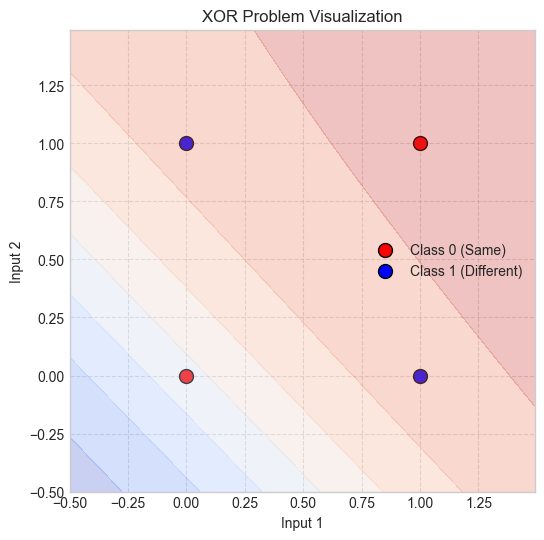

In [18]:
plot_xor(model)

### Conclusion:
**It works!** 

Notice the decision boundary in the plot above. It is no longer a straight line. The neural network has learned a curved region that successfully isolates the Class 1 points (blue) from the Class 0 points (red).

By adding a single hidden layer with non-linear activation functions, we transformed a linearly inseparable problem into a solvable one.

## 5. Universal Approximation Theorem (The Theory)

We just saw a practical example of a fundamental theorem in Deep Learning.

The **Universal Approximation Theorem** effectively states:
> A feed-forward network with a single hidden layer containing a finite number of neurons can approximate **any** continuous function to any desired degree of accuracy, provided reasonable activation functions are used.

**What this means for you:**
1. **Versatility**: Neural Networks are "Universal Function Approximators". Whether the relationship between your input (pixels, audio, text) and output (cat/dog, transcript, sentiment) is simple or incredibly complex, a neural network can theoretically learn it.
2. **Capacity**: The key constraint is the number of neurons. Deeper and wider networks have more "capacity" to learn more complex interactions.

In this lab, we used a "Shallow" network (1 hidden layer). Deep Learning is simply the practice of scaling this up to many, many layers to learn increasingly abstract representations of data.